<a href="https://colab.research.google.com/github/jaydeepthik/UNET-semantic-segmentation/blob/master/salt_semantic_segmentation_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/tgs-salt-identification-challenge')

In [2]:
os.listdir()

['depths.csv',
 'sample_submission.csv',
 'train.csv',
 'competition_data.zip',
 'flamingo.zip',
 'test.zip',
 'train.zip',
 'salt-semantic-segmentation-unet.ipynb']

In [0]:
!unzip '/content/drive/My Drive/Colab Notebooks/tgs-salt-identification-challenge/train.zip'

In [0]:
assert len(os.listdir(os.path.join('images'))) == len(os.listdir(os.path.join('masks')))

In [0]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

import keras
from keras.preprocessing.image import img_to_array, load_img
from keras.optimizers import Adam

from skimage.transform import resize
from sklearn.model_selection import train_test_split


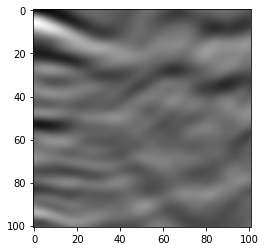

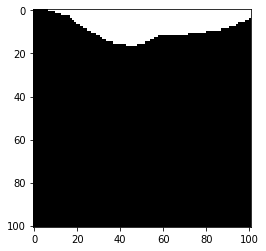

In [7]:
# visualize the data
img = cv2.imread('images/'+os.listdir(os.path.join('images'))[0])
plt.imshow(img, cmap='seismic', interpolation='bilinear')
plt.show()

msk = cv2.imread('masks/'+os.listdir(os.path.join('masks'))[0])
plt.imshow(msk, cmap='seismic')
plt.show()

In [8]:
h = 128
w = 128
ch = 1
tot_images = len(os.listdir(os.path.join('images')))

X = np.zeros((tot_images, h, w, ch), dtype='float32')
y = np.zeros((tot_images, h, w, ch), dtype='float32')

i=0
for img_path, mask_path in zip(os.listdir(os.path.join('images')), os.listdir(os.path.join('masks'))):
  img = load_img("images/"+img_path, grayscale=True)
  x_img = img_to_array(img)
  x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)


  msk = load_img("masks/"+mask_path, grayscale=True)
  msk = img_to_array(msk)
  msk = resize(msk, (128, 128, 1), mode = 'constant', preserve_range = True)

  X[i] = x_img/255.0
  y[i] = msk/255.0
  i+=1


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

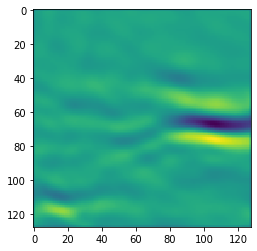

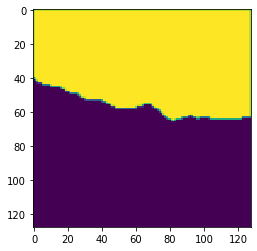

In [10]:
plt.imshow(X[1430].reshape(128,128))
plt.show()

plt.imshow(y[1430].reshape(128,128))
plt.show()

In [0]:
def conv2d_layer(input_t, num_filters, kernel_size=3, batch_norm = True):
  x = keras.layers.Conv2D(filters=num_filters, kernel_size=kernel_size, padding='SAME', kernel_initializer='he_normal')(input_t)
  if batch_norm:
    x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation('relu')(x)

  x = keras.layers.Conv2D(filters=num_filters, kernel_size=kernel_size, padding='SAME', kernel_initializer='he_normal')(x)
  if batch_norm:
    x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation('relu')(x)
  return x

In [0]:
def UNET_Model(input_t, base_filters = 32, batch_norm = True):
  c1 = conv2d_layer(input_t, base_filters, kernel_size=3, batch_norm = batch_norm)
  p1 = keras.layers.MaxPooling2D()(c1)
  p1 = keras.layers.Dropout(0.2)(p1)

  c2 = conv2d_layer(p1, base_filters*2)
  p2 = keras.layers.MaxPooling2D()(c2)
  p2 = keras.layers.Dropout(0.2)(p2)

  c3 = conv2d_layer(p2, base_filters*4)
  p3 = keras.layers.MaxPooling2D()(c3)
  p3 = keras.layers.Dropout(0.2)(p3)

  c4 = conv2d_layer(p3, base_filters*8)
  p4 = keras.layers.MaxPooling2D()(c4)
  p4 = keras.layers.Dropout(0.2)(p4)

  c5 = conv2d_layer(p4, base_filters*16)

  u6 = keras.layers.Conv2DTranspose(base_filters * 8, (3, 3), strides=(2,2),  padding = 'same')(c5)
  u6 = keras.layers.concatenate([u6, c4])
  u6 = keras.layers.Dropout(0.2)(u6)
  c6 = conv2d_layer(u6, base_filters * 8, kernel_size = 3, batch_norm = batch_norm)

  u7 = keras.layers.Conv2DTranspose(base_filters * 4, (3, 3), strides=(2,2), padding = 'same')(c6)
  u7 = keras.layers.concatenate([u7, c3])
  u7 = keras.layers.Dropout(0.2)(u7)
  c7 = conv2d_layer(u7, base_filters * 4, kernel_size = 3, batch_norm = batch_norm)

  u8 = keras.layers.Conv2DTranspose(base_filters * 2, (3, 3), strides=(2,2), padding = 'same')(c7)
  u8 = keras.layers.concatenate([u8, c2])
  u8 = keras.layers.Dropout(0.2)(u8)
  c8 = conv2d_layer(u8, base_filters * 2, kernel_size = 3, batch_norm = batch_norm)

  u9 = keras.layers.Conv2DTranspose(base_filters, (3, 3), strides=(2,2), padding = 'same')(c8)
  u9 = keras.layers.concatenate([u9, c1])
  u9 = keras.layers.Dropout(0.2)(u9)
  c9 = conv2d_layer(u9, base_filters, kernel_size = 3, batch_norm = batch_norm)

  output = keras.layers.Conv2D(1,1, activation='sigmoid')(c9)
  model = keras.models.Model(inputs=[input_t], outputs=[output])
  
  return model

In [15]:
input_layer = keras.layers.Input((h, w, 1))
unet_model = UNET_Model(input_layer, base_filters=32, batch_norm=True)

unet_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['acc'])
unet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 128, 128, 32) 128         conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 128, 128, 32) 0           batch_normalization_19[0][0]     
____________________________________________________________________________________________

In [16]:
history = unet_model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_test, y_test))

Train on 2800 samples, validate on 1200 samples
Epoch 1/20
2800/2800 [==============================] - 16s 6ms/step - loss: 0.6031 - acc: 0.6762 - val_loss: 1.4135 - val_acc: 0.6744
Epoch 2/20
2800/2800 [==============================] - 11s 4ms/step - loss: 0.4209 - acc: 0.8429 - val_loss: 1.5159 - val_acc: 0.5953
Epoch 3/20
2800/2800 [==============================] - 11s 4ms/step - loss: 0.3561 - acc: 0.8750 - val_loss: 1.1195 - val_acc: 0.6386
Epoch 4/20
2800/2800 [==============================] - 11s 4ms/step - loss: 0.3211 - acc: 0.8840 - val_loss: 0.4473 - val_acc: 0.8233
Epoch 5/20
2800/2800 [==============================] - 11s 4ms/step - loss: 0.3071 - acc: 0.8841 - val_loss: 0.3915 - val_acc: 0.8359
Epoch 6/20
2800/2800 [==============================] - 11s 4ms/step - loss: 0.2929 - acc: 0.8845 - val_loss: 1.3714 - val_acc: 0.6019
Epoch 7/20
2800/2800 [==============================] - 11s 4ms/step - loss: 0.2754 - acc: 0.8918 - val_loss: 0.6111 - val_acc: 0.8408
Epoch 8

:INPUT:


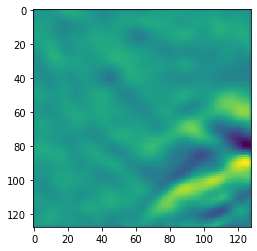

:ACTUAL:


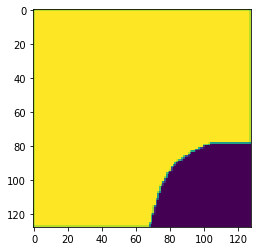

:PREDICTED:


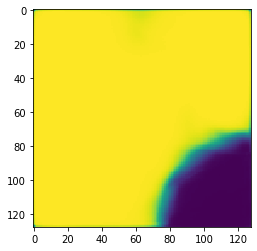

In [27]:
idex = 651

pred = unet_model.predict(X_test[idex].reshape(1,h,w,ch))
print(":INPUT:")
plt.imshow(X_test[idex].reshape(h, w))
plt.show()

print(":ACTUAL:")
plt.imshow(y_test[idex].reshape(h, w))
plt.show()

print(":PREDICTED:")
plt.imshow(pred[0].reshape(h, w))
plt.show()